### State Schema With DataClasses
When we define a LangGraph StateGraph, we use a state schema.

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python types and validation approaches!

 we can use the TypedDict class from python's typing module.

It allows you to specify keys and their corresponding value types.

But, note that these are type hints.

They can be used by static type checkers (like mypy) or IDEs to catch potential type-related errors before the code is run.

But they are not enforced at runtime!


In [1]:
from typing_extensions import TypedDict
from typing import Literal

class TypedDictState(TypedDict):
    name:str
    game:Literal["cricket","badminton"]

In [2]:
def play_game(state:TypedDictState):
    print("---Play Game node has been called--")
    return {"name":state['name'] + " wants to play "}

def cricket(state:TypedDictState):
    print("-- Cricket node has been called--")
    return {"name":state["name"] + " cricket","game":"cricket"}

def badminton(state:TypedDictState):
    print("-- badminton node has been called--")
    return {"name":state["name"] + " badminton","game":"badminton"}

In [3]:
import random
def decide_play(state:TypedDictState)->Literal["cricket","badminton"]:
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        return "cricket"
    else:
        return "badminton"

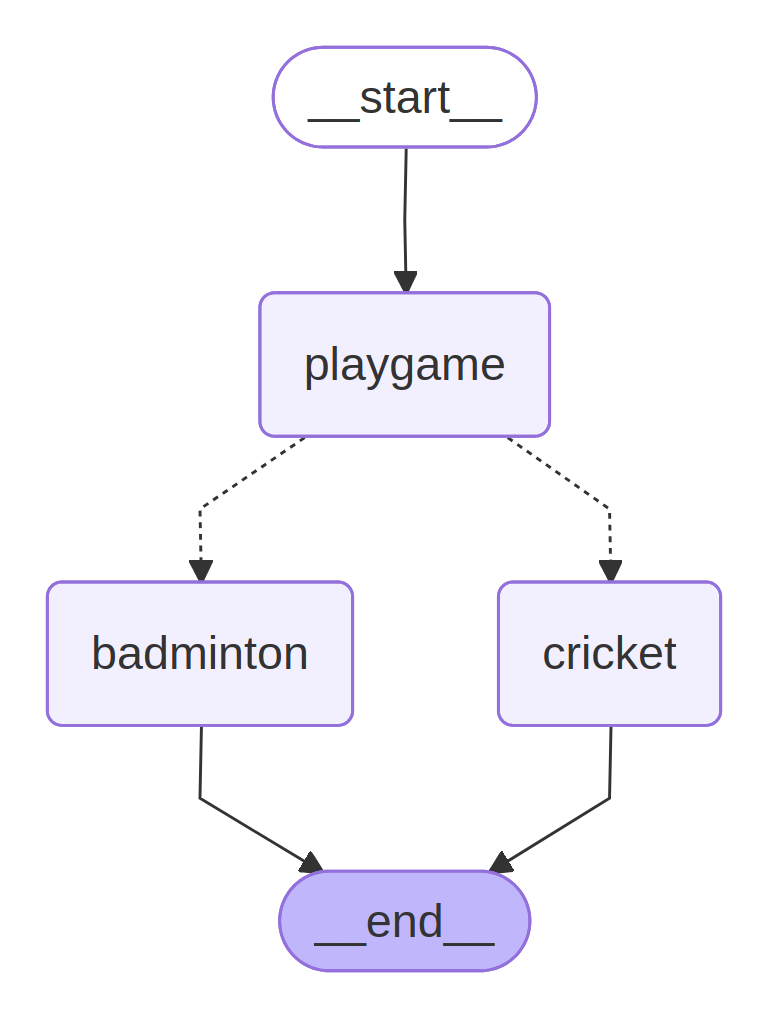

In [4]:

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

builder=StateGraph(TypedDictState)
builder.add_node("playgame",play_game)
builder.add_node("cricket",cricket)
builder.add_node("badminton",badminton)

## Flow of the graph

builder.add_edge(START,"playgame")
builder.add_conditional_edges("playgame",decide_play)
builder.add_edge("cricket",END)
builder.add_edge("badminton",END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [5]:
graph.invoke({"name":"Saib"})

---Play Game node has been called--
-- badminton node has been called--


{'name': 'Saib wants to play  badminton', 'game': 'badminton'}

In [22]:
graph.invoke({"name":"Saib", "game":"cricket"})

---Play Game node has been called--
-- badminton node has been called--


{'name': 'Saib wants to play  badminton', 'game': 'badminton'}

In [6]:
graph.invoke({"name":123}) # This will not raise an error at runtime, but a static type checker would flag this as a type mismatch.

---Play Game node has been called--


TypeError: unsupported operand type(s) for +: 'int' and 'str'

### Pydantic (Python )

### Dataclasses
Python's dataclasses provide another way to define structured data.

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [7]:
### DataClasses

from dataclasses import dataclass

@dataclass
class DataClassState:
    name:str
    game:Literal["badminton","cricket"]

In [8]:
def play_game(state:DataClassState):
    print("---Play Game node has been called--")
    return {"name":state.name + " want to play "}

def cricket(state:DataClassState):
    print("-- Cricket node has been called--")
    return {"name":state.name + " cricket","game":"cricket"}

def badminton(state:DataClassState):
    print("-- badminton node has been called--")
    return {"name":state.name + " badminton","game":"badminton"}

In [9]:
import random
def decide_play(state:DataClassState)->Literal["cricket","badminton"]:
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        return "cricket"
    else:
        return "badminton"

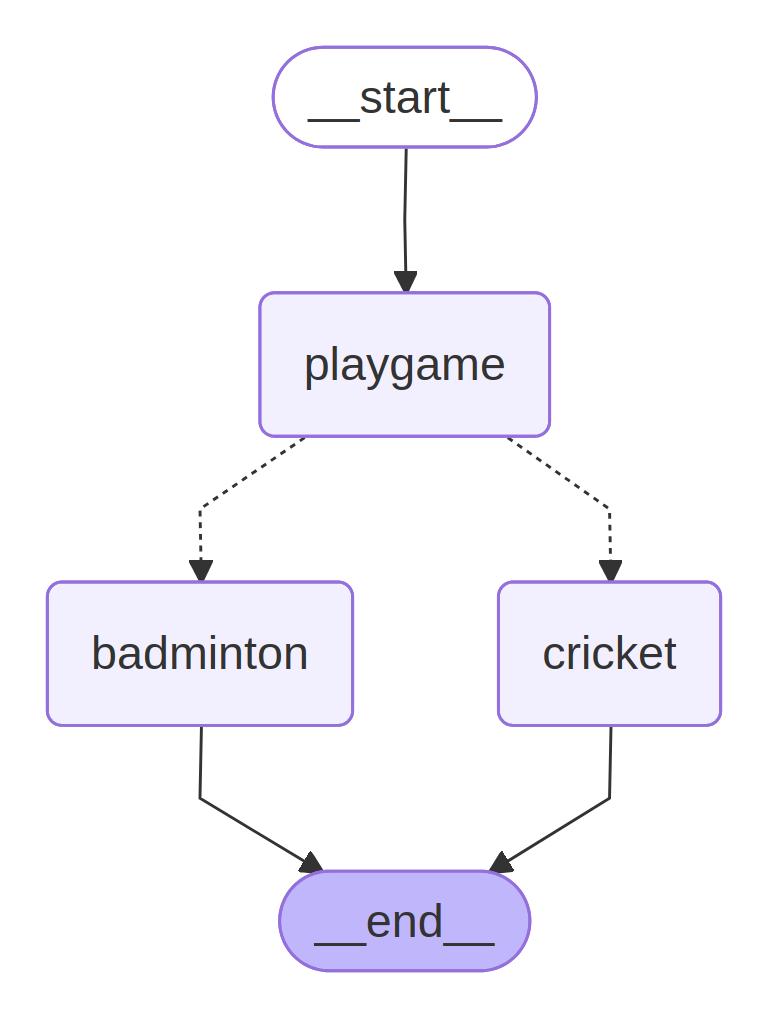

In [10]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()


builder=StateGraph(DataClassState)
builder.add_node("playgame",play_game)
builder.add_node("cricket",cricket)
builder.add_node("badminton",badminton)

## Flow of the graph

builder.add_edge(START,"playgame")
builder.add_conditional_edges("playgame",decide_play)
builder.add_edge("cricket",END)
builder.add_edge("badminton",END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [11]:
graph.invoke(DataClassState(name="Saib",game="cricket"))

---Play Game node has been called--
-- Cricket node has been called--


{'name': 'Saib want to play  cricket', 'game': 'cricket'}

- TypedDict: Behaves like a dictionary, flexible with missing keys
- DataClass: Behaves like a class, requires all fields at initialization

In [13]:
# TypedDict - missing 'game' key is allowed
graph.invoke({"name": "Saib"})  # ✓ Works

# The decide_play function will add the 'game' key later
def decide_play(state: TypedDictState) -> Literal["cricket","badminton"]:
    return "cricket"  # This gets added to state

---Play Game node has been called--
-- Cricket node has been called--


{'name': 'Saib want to play  cricket', 'game': 'cricket'}

In [ ]:
# DataClass - all fields must be provided at creation
graph.invoke(DataClassState(name="Saib", game="cricket"))  # ✓ Works
graph.invoke(DataClassState(name="Saib"))  # ✗ Error - missing required field

### Pydantic Schema
Pydantic provides data validation and parsing using Python type annotations.

Unlike TypedDict (type hints only) and dataclasses (basic structure), Pydantic enforces validation at runtime and provides excellent error messages for invalid data.

In [14]:
from pydantic import BaseModel

class PydanticState(BaseModel):
    name: str
    game: Literal["badminton", "cricket"]

In [15]:
def play_game(state: PydanticState):
    print("---Play Game node has been called--")
    return {"name": state.name + " wants to play "}

def cricket(state: PydanticState):
    print("-- Cricket node has been called--")
    return {"name": state.name + " cricket", "game": "cricket"}

def badminton(state: PydanticState):
    print("-- badminton node has been called--")
    return {"name": state.name + " badminton", "game": "badminton"}

In [16]:
import random
def decide_play(state: PydanticState) -> Literal["cricket", "badminton"]:
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        return "cricket"
    else:
        return "badminton"

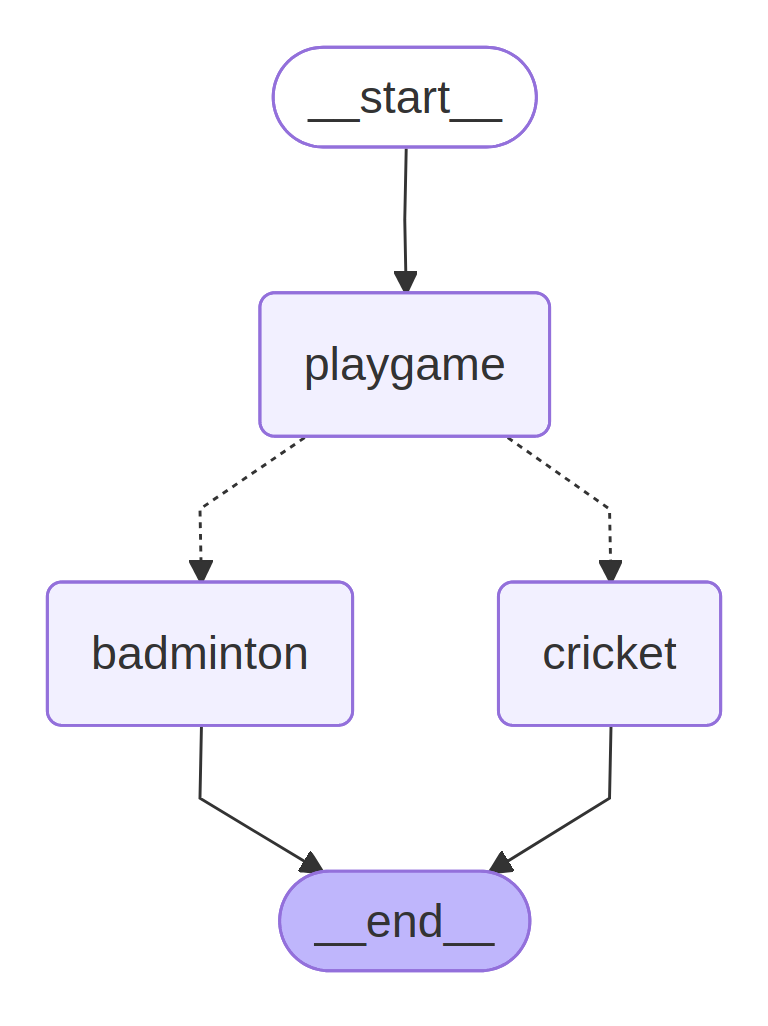

In [17]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

builder = StateGraph(PydanticState)
builder.add_node("playgame", play_game)
builder.add_node("cricket", cricket)
builder.add_node("badminton", badminton)

## Flow of the graph
builder.add_edge(START, "playgame")
builder.add_conditional_edges("playgame", decide_play)
builder.add_edge("cricket", END)
builder.add_edge("badminton", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [18]:
# Test with valid data
graph.invoke(PydanticState(name="Saib", game="cricket"))

---Play Game node has been called--
-- badminton node has been called--


{'name': 'Saib wants to play  badminton', 'game': 'badminton'}

In [19]:
# Test with invalid data - this will raise a validation error at creation time
try:
    invalid_state = PydanticState(name=123, game="football")
    print("Created invalid state:", invalid_state)
except Exception as e:
    print("Validation error:", e)

Validation error: 2 validation errors for PydanticState
name
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
game
  Input should be 'badminton' or 'cricket' [type=literal_error, input_value='football', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/literal_error


In [20]:
# Test with valid data
graph.invoke(PydanticState(name="Saib"))

ValidationError: 1 validation error for PydanticState
game
  Field required [type=missing, input_value={'name': 'Saib'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

### Comparison of All Three Approaches

| Schema Type | Runtime Validation | Syntax | Missing Fields | Invalid Types | Use Case |
|-------------|-------------------|---------|----------------|---------------|----------|
| **TypedDict** | ❌ No | Dictionary `{"name": "Saib"}` | Allowed | Ignored | Simple, flexible |
| **DataClass** | ❌ No | Constructor `DataClassState(name="Saib", game="cricket")` | Constructor error | Ignored | Structured classes |
| **Pydantic** | ✅ Yes | Constructor `PydanticState(name="Saib", game="cricket")` | Validation error | Validation error | Data validation |

**Key Advantages:**
- **TypedDict**: Most flexible, allows partial state
- **DataClass**: Clean syntax, good for simple structures  
- **Pydantic**: Catches errors early with runtime validation

In [24]:
# # TypedDict - can start incomplete
# graph.invoke({"name": "Saib"})
# # Flow: START → playgame → decide_play() → cricket/badminton → END

# # DataClass - must start complete  
# graph.invoke(DataClassState(name="Saib", game="cricket"))
# # Flow: START → playgame → decide_play() → cricket/badminton → END

# # Pydantic - must start complete
# graph.invoke(PydanticState(name="Saib", game="cricket")) 
# # Flow: START → playgame → decide_play() → cricket/badminton → END